In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import cf_xarray
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import polars as pl
import pandas as pd
import pprint
import string
import os
import sys
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import scienceplots
plt.style.use(["nature", "notebook"])
%load_ext rich

In [2]:
results_dir = os.getcwd()+'/Results/'
fig_dir = os.getcwd()+'/Figures/'

## Coerce to xarray dataset

In [3]:
from DLEMinputs import create_interpolation_grid
ncols, nrows, lons, lats, no_data_value = create_interpolation_grid()

In [34]:
np.max(np.fromfile(dlem_files[i], dtype=np.float32).reshape([292, 693])[np.newaxis, :, :])

593213760.0

In [36]:
for crop in tqdm(['corn', 'soybean']):
    dlem_files = sorted(glob(results_dir+f'DLEM/{crop}_production/{crop.capitalize()}*.bin'))
    cesm_files = sorted(glob(results_dir+f'CESM2/{crop}_production/{crop.capitalize()}*.bin'))
    xrs = []
    for i, y in enumerate(range(1970, 2010)):
        dlem_np = np.fromfile(dlem_files[i], dtype=np.float32).reshape([292, 693])[np.newaxis, :, :]
        cesm_np = np.fromfile(cesm_files[i], dtype=np.float32).reshape([292, 693])[np.newaxis, :, :]
        dlem_np = np.where(dlem_np == 0, np.nan, dlem_np)
        cesm_np = np.where(cesm_np == 0, np.nan, cesm_np)
        # Create the xarray dataset
        dlem_xr = xr.Dataset(
            {
                # g to kg
                f'DLEM': (['time', 'lat', 'lon'], dlem_np),
                f'CESM2': (['time', 'lat', 'lon'], cesm_np),
            },
            coords={
                'time': np.atleast_1d(pd.to_datetime(y, format='%Y')),
                'lat': lats,
                'lon': lons
            },
            attrs={
                'units': 'kg'
            }
        )
        xrs.append(dlem_xr)
    # Concatenate the datasets
    xrs = xr.concat(xrs, dim='time')
    # Save the dataset
    xrs.to_netcdf(results_dir+f'{crop}_production.nc')
    

100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


## Plots

In [76]:
corn = xr.load_dataset('Results/corn_production.nc')
corn = corn.where(corn['CESM2']>=0, drop=True)
soybean = xr.load_dataset('Results/soybean_production.nc')
soybean = soybean.where(soybean['CESM2']>=0, drop=True)

## Need to do county aggregation

In [98]:
county_corn_sum = (
    corn.to_dataframe()
    .groupby('time')
    .agg(lambda x: np.nansum(x.unique()))
    .reset_index()
)
county_soybean_sum = (
    soybean.to_dataframe()
    .groupby('time')
    .agg(lambda x: np.nansum(x.unique()))
    .reset_index()
)
# -1 to number of unique to account for NaN
county_corn_mean = (
    corn.to_dataframe()
    .groupby('time')
    .agg(lambda x: np.nansum(x.unique())/(len(x.unique())-1))
    .reset_index()
)
county_soybean_mean = (
    corn.to_dataframe()
    .groupby('time')
    .agg(lambda x: np.nansum(x.unique())/(len(x.unique())-1))
    .reset_index()
)


### Average production

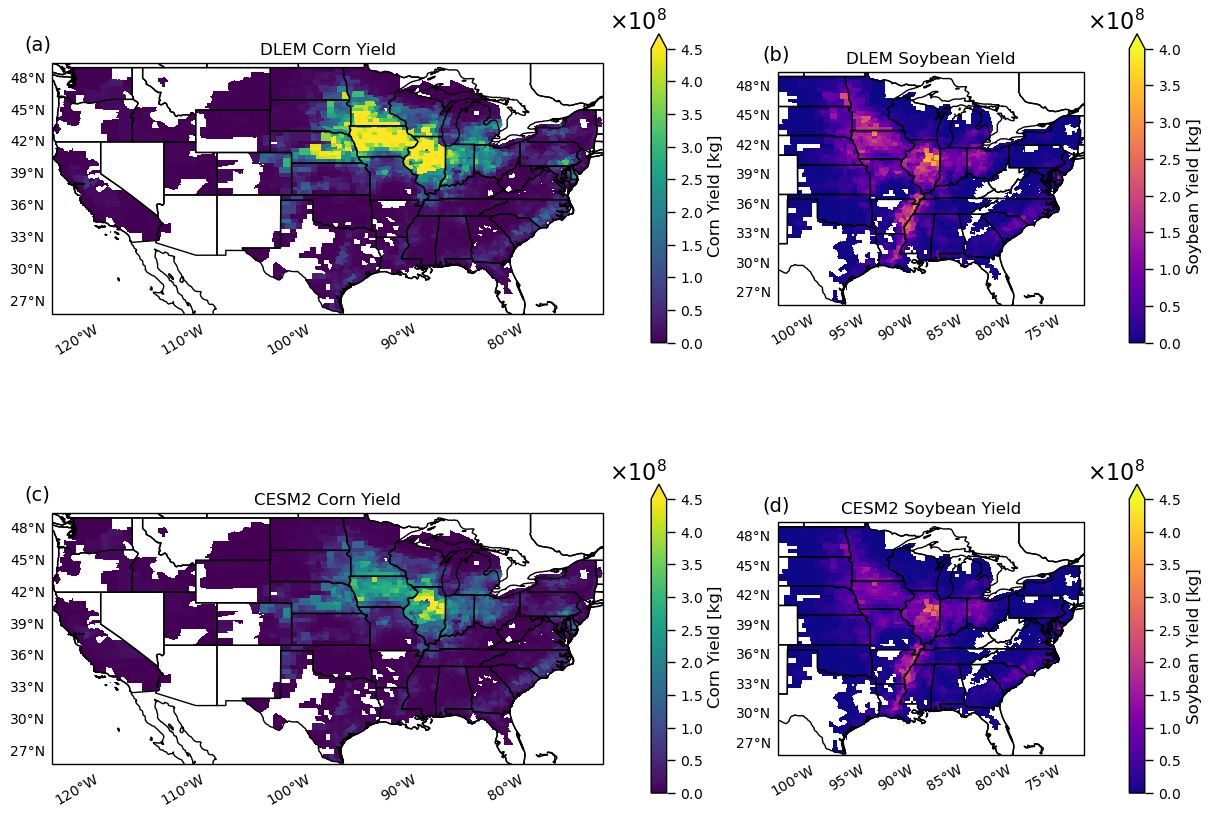

In [105]:
mean_corn = corn.mean('time')
mean_soybean = soybean.mean('time')
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 2, width_ratios=[1.8, 1])
ax = np.array([
    [fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())],
    [fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())],
])
im = mean_corn['DLEM'].plot(
    ax=ax[0,0], transform=ccrs.PlateCarree(), cmap='viridis', 
    add_colorbar=False, vmin=0, vmax=450000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Corn Yield [kg]', fontsize=12)
im = mean_corn['CESM2'].plot(
    ax=ax[1, 0], transform=ccrs.PlateCarree(), cmap='viridis',
    add_colorbar=False, vmin=0, vmax=450000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Corn Yield [kg]', fontsize=12)
im = mean_soybean['DLEM'].plot(
    ax=ax[0, 1], transform=ccrs.PlateCarree(), cmap='plasma',
    add_colorbar=False, vmin=0, vmax=400000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Soybean Yield [kg]', fontsize=12)
im = mean_soybean['CESM2'].plot(
    ax=ax[1, 1], transform=ccrs.PlateCarree(), cmap='plasma', 
    add_colorbar=False, vmin=0, vmax=450000000
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='max', shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Soybean Yield [kg]', fontsize=12)
# Add titles to the plots
ax[0, 0].set_title('DLEM Corn Yield', fontsize=12)
ax[1, 0].set_title('CESM2 Corn Yield', fontsize=12)
ax[0, 1].set_title('DLEM Soybean Yield', fontsize=12)
ax[1, 1].set_title('CESM2 Soybean Yield', fontsize=12)

for n, ax in enumerate(ax.flat):
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
plt.savefig(fig_dir+'mean_production.png', dpi=300, bbox_inches='tight')
plt.show()

### Bias in mean production

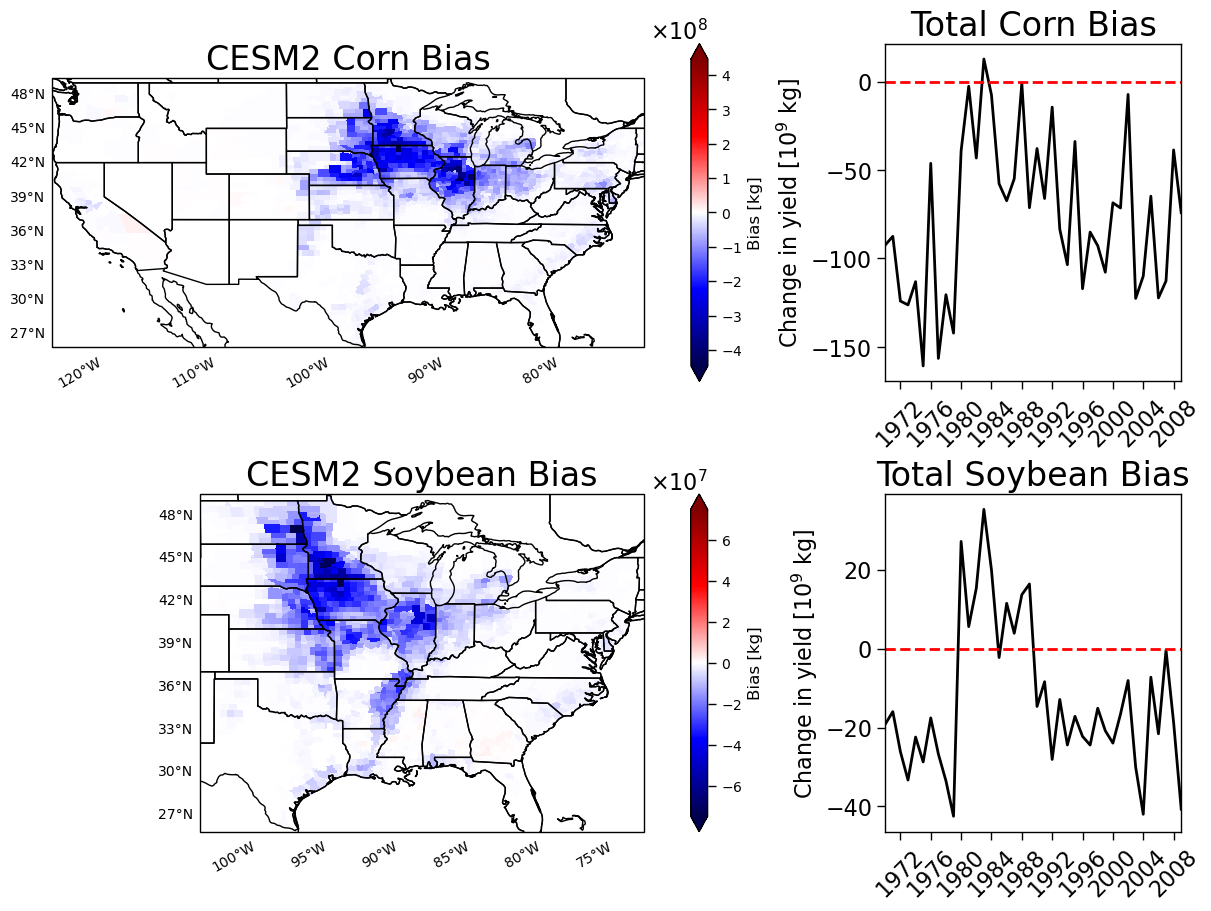

In [111]:
corn_bias = corn['CESM2']-corn['DLEM']
soybean_bias = soybean['CESM2']-soybean['DLEM']

county_corn_bias = county_corn_sum['CESM2']-county_corn_sum['DLEM']
county_soybean_bias = county_soybean_sum['CESM2']-county_soybean_sum['DLEM']

fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = corn_bias.mean('time').plot(
    ax=ax1, transform=ccrs.PlateCarree(), cmap='seismic', 
    add_colorbar=False
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=1)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [kg]', fontsize=12)
ax1.set_title('CESM2 Corn Bias', fontsize=24)
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = soybean_bias.mean('time').plot(
    ax=ax2, transform=ccrs.PlateCarree(), cmap='seismic',
    add_colorbar=False,
    )
cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=1)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [kg]', fontsize=12)
ax2.set_title('CESM2 Soybean Bias', fontsize=24)
# Time series
ax = fig.add_subplot(gs[0, 1])
ax.plot(county_corn_sum['time'], county_corn_bias/10**9, label='DLEM', c='k')
ax.set_title('Total Corn Bias', fontsize=24)
ax.tick_params(axis='x', rotation=45)
ax.set_xlim([pd.to_datetime('1970-01-01'), pd.to_datetime('2009-01-01')])
ax.set_ylabel('Change in yield [$10^{9}$ kg]')
ax.axhline(y=0, c='red', linestyle='--')
ax = fig.add_subplot(gs[1, 1])
ax.plot(county_soybean_sum['time'], county_soybean_bias/10**9, label='DLEM', c='k')
ax.set_title('Total Soybean Bias', fontsize=24)
ax.tick_params(axis='x', rotation=45)
ax.set_xlim([pd.to_datetime('1970-01-01'), pd.to_datetime('2009-01-01')])
ax.set_ylabel('Change in yield [$10^{9}$ kg]')
ax.axhline(y=0, c='red', linestyle='--')

for ax in [ax1, ax2]:
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
plt.savefig(fig_dir+'mean_bias.png', dpi=300, bbox_inches='tight')
plt.show()

## Production over time

Use the Kendall-Tau statistic because it is non-paremetric (no assumptions about distribution) and the relationship need not be linear.

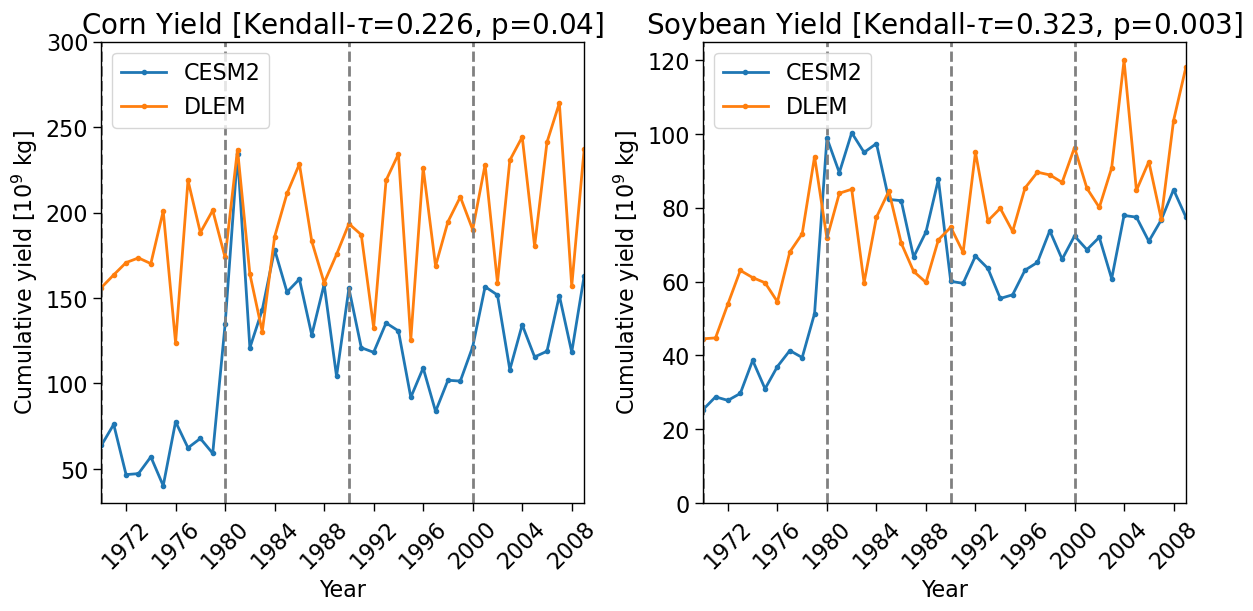

In [125]:
from scipy.stats import kendalltau
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax = np.array([fig.add_subplot(gs[0]), fig.add_subplot(gs[1])])
# Corn
ax[0].plot(county_corn_sum['time'], (county_corn_sum['CESM2']/10**9), label='CESM2', marker='o')
ax[0].plot(county_corn_sum['time'], (county_corn_sum['DLEM']/10**9), label='DLEM', marker='o')
ax[0].set_xlim([pd.to_datetime('1970-01-01'), pd.to_datetime('2009-01-01')])
ax[0].tick_params(axis='x', rotation=45)
k, p_val = kendalltau((county_corn_sum['CESM2']/10**9), (county_corn_sum['DLEM']/10**9))
ax[0].vlines([pd.to_datetime(f'{y}-01-01') for y in [1970, 1980, 1990, 2000]], 30, 300, color='gray', linestyle='--')
ax[0].set_ylim([30, 300])
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel(r'Cumulative yield [$10^{9}$ kg]')
ax[0].set_title(r'Corn Yield [Kendall-$\tau$='+str(round(k, 3))+', p='+str(round(p_val, 3))+']', fontsize=20)
# Soybean
ax[1].plot(county_soybean_sum['time'], (county_soybean_sum['CESM2']/10**9), label='CESM2', marker='o')
ax[1].plot(county_soybean_sum['time'], (county_soybean_sum['DLEM']/10**9), label='DLEM', marker='o')
ax[1].set_xlim([pd.to_datetime('1970-01-01'), pd.to_datetime('2009-01-01')])
ax[1].vlines([pd.to_datetime(f'{y}-01-01') for y in [1970, 1980, 1990, 2000]], 0, 125, color='gray', linestyle='--')
ax[1].set_ylim([0, 125])
ax[1].tick_params(axis='x', rotation=45)
k, p_val = kendalltau((county_soybean_sum['CESM2']/10**9), (county_soybean_sum['DLEM']/10**9))
ax[1].legend()
ax[1].set_xlabel('Year')
ax[1].set_ylabel(r'Cumulative yield [$10^{9}$ kg]')
ax[1].set_title(r'Soybean Yield [Kendall-$\tau$='+str(round(k, 3))+', p='+str(round(p_val, 3))+']', fontsize=20)
plt.savefig(fig_dir+'yield_over_time.png', dpi=300, bbox_inches='tight')
plt.show()


## Climate model biases

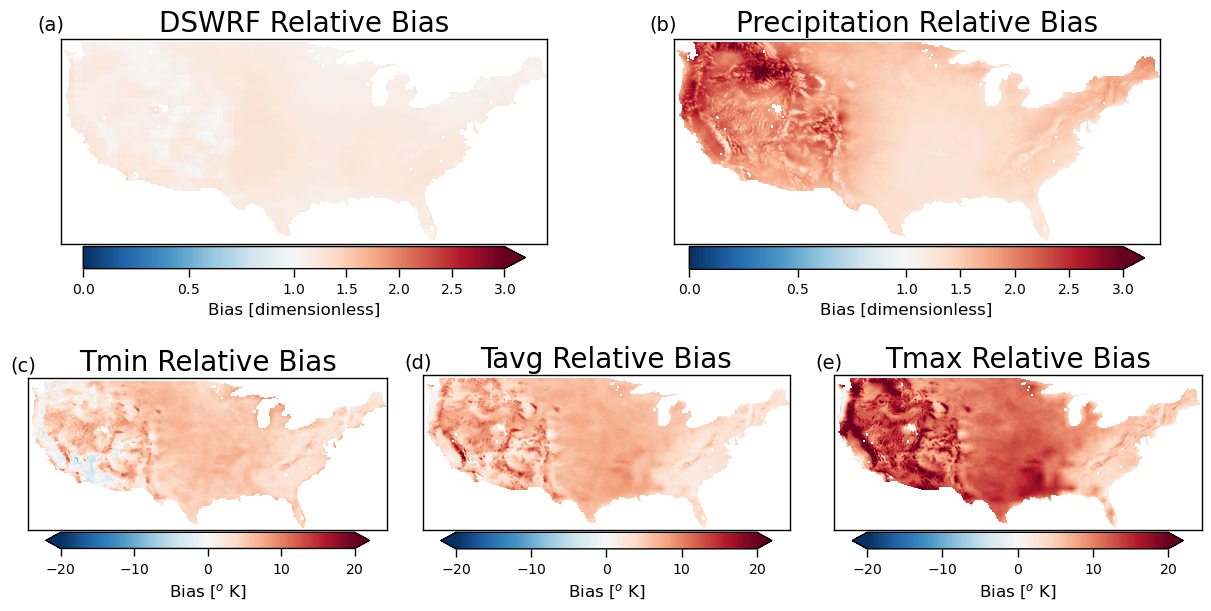

In [63]:
dswrf_bias = np.fromfile('ClimateDataComparison/Bias/dswrf/dswrf_2000_relative_bias.bin', dtype=np.float32).reshape([292, 693])
pr_bias = np.fromfile('ClimateDataComparison/Bias/pr/pr_2000_relative_bias.bin', dtype=np.float32).reshape([292, 693])
tavg_bias = np.fromfile('ClimateDataComparison/Bias/Tavg/Tavg_2000_mean_bias.bin', dtype=np.float32).reshape([292, 693])
tmax_bias = np.fromfile('ClimateDataComparison/Bias/Tmax/Tmax_2000_mean_bias.bin', dtype=np.float32).reshape([292, 693])  
tmin_bias = np.fromfile('ClimateDataComparison/Bias/Tmin/Tmin_2000_mean_bias.bin', dtype=np.float32).reshape([292, 693])
# Remove the no data for delta correction
tavg_bias = np.where(tavg_bias <= -99, np.nan, tavg_bias)
tmin_bias = np.where(tmin_bias <= -99, np.nan, tmin_bias)
tmax_bias = np.where(tmax_bias <= -99, np.nan, tmax_bias)
tavg_bias = np.where(tavg_bias == 0, np.nan, tavg_bias)
tmin_bias = np.where(tmin_bias == 0, np.nan, tmin_bias)
tmax_bias = np.where(tmax_bias == 0, np.nan, tmax_bias)
# Remove the no data for the relative bias
dswrf_bias = np.where(dswrf_bias == 1, np.nan, dswrf_bias)
pr_bias = np.where(pr_bias == 1, np.nan, pr_bias)
dswrf_bias = np.where(dswrf_bias <= 0.001, np.nan, dswrf_bias)
pr_bias = np.where(pr_bias <= 0.001, np.nan, pr_bias)
# Make Plot
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 6, width_ratios=[1, 1, 1, 1, 1, 1])
ax = np.array([
    fig.add_subplot(gs[0, 0:3]),
    fig.add_subplot(gs[0, 3:]),
    fig.add_subplot(gs[1, 0:2]),
    fig.add_subplot(gs[1, 2:4]),
    fig.add_subplot(gs[1, 4:]),
])
# Relative bias correctiondiv
norm=colors.TwoSlopeNorm(vmin=0., vcenter=1, vmax=3)
im = ax[0].imshow(dswrf_bias, cmap='RdBu_r', norm=norm)
cb = plt.colorbar(im, orientation="horizontal", pad=0.01, extend='max', shrink=0.8)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [dimensionless]', fontsize=12)
ax[0].set_title('DSWRF Relative Bias', fontsize=20)

im = ax[1].imshow(pr_bias, cmap='RdBu_r', norm=norm)
cb = plt.colorbar(im, orientation="horizontal", pad=0.01, extend='max', shrink=0.8)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [dimensionless]', fontsize=12)
ax[1].set_title('Precipitation Relative Bias', fontsize=20)

# Delta bias
im = ax[2].imshow(tmin_bias, cmap='RdBu_r', vmin=-20, vmax=20)
cb = plt.colorbar(im, orientation="horizontal", pad=0.01, extend='both', shrink=0.9)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [$^o$ K]', fontsize=12)
ax[2].set_title('Tmin Relative Bias', fontsize=20)

im = ax[3].imshow(tavg_bias, cmap='RdBu_r', vmin=-20, vmax=20)
cb = plt.colorbar(im, orientation="horizontal", pad=0.01, extend='both', shrink=0.9)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [$^o$ K]', fontsize=12)
ax[3].set_title('Tavg Relative Bias', fontsize=20)

im = ax[4].imshow(tmax_bias, cmap='RdBu_r', vmin=-20, vmax=20)
cb = plt.colorbar(im, orientation="horizontal", pad=0.01, extend='both', shrink=0.9)
cb.ax.tick_params(labelsize=10)
cb.formatter.set_useMathText(True)
cb.set_label(label='Bias [$^o$ K]', fontsize=12)
ax[4].set_title('Tmax Relative Bias', fontsize=20)
for n, ax in enumerate(ax.flat):
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig(fig_dir+'climate_bias.png', dpi=300, bbox_inches='tight')
plt.show()